In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

plt.style.use("seaborn-v0_8")
DATA_PATH = Path("../data/ts2024.csv")

# --- Load and preprocess ---
df = pd.read_csv(DATA_PATH)
df["DateTime_fixed"] = df["DateTime"].apply(lambda x: x if " " in x else f"{x} 00:00:00")
df["DateTime"] = pd.to_datetime(df["DateTime_fixed"], errors="coerce")
df.drop(columns=["DateTime_fixed"], inplace=True)
df["Date"] = df["DateTime"].dt.date
df["Hour"] = df["DateTime"].dt.hour

H = 744
test  = df.iloc[-H:]
valid = df.iloc[-2*H:-H]
train = df.iloc[:-2*H]


In [2]:

SEASON_LIST = [{"period": 24, "harmonics": 12}]
MODEL_A = dict(level="local linear trend", freq_seasonal=SEASON_LIST)

def fit_ucm(endog, model_kwargs, exog=None):
    return UCM(endog, exog=exog, **model_kwargs).fit(disp=False)

def forecast_and_score(fit_res, steps, truth=None):
    pred = fit_res.forecast(steps=steps)
    if truth is not None:
        mask = truth.notna()
        mae = mean_absolute_error(truth[mask].values, pred.values[mask])
    else:
        mae = None
    return pred, mae


In [8]:
print(f"Validation MAE (Model A): {mae_valid_A:.4f}")

Validation MAE (Model A): 0.0239


In [3]:

fit_A = fit_ucm(train["X"], model_kwargs=MODEL_A)
print("Model A fitted.")
print(fit_A.summary())

pred_valid_A, mae_valid_A = forecast_and_score(fit_A, H, truth=valid["X"])
print(f"Validation MAE (Model A): {mae_valid_A:.4f}")

trainval = pd.concat([train, valid])
fit_A_final = fit_ucm(trainval["X"], model_kwargs=MODEL_A)

forecast_all = fit_A_final.forecast(steps=len(test))
test_clean = test[["X"]].copy()
test_clean["UCM"] = forecast_all.values


Model A fitted.
                                Unobserved Components Results                                 
Dep. Variable:                                      X   No. Observations:                16056
Model:                             local linear trend   Log Likelihood               30915.008
                   + stochastic freq_seasonal(24(12))   AIC                         -61822.016
Date:                                Sun, 13 Jul 2025   BIC                         -61791.287
Time:                                        15:05:22   HQIC                        -61811.853
Sample:                                             0                                         
                                              - 16056                                         
Covariance Type:                                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [4]:

weekly_model = dict(level="local linear trend", freq_seasonal=[{"period": 7, "harmonics": 3}])
residuals_hourly = []
preds_test = []
preds_valid = []
mae_valid_B_by_hour = []

for h in range(24):
    trainval_h = trainval[trainval["Hour"] == h]
    test_h = test[test["Hour"] == h]
    valid_h = valid[valid["Hour"] == h]

    fit_h = UCM(trainval_h["X"], **weekly_model).fit(disp=False)

    pred_test = fit_h.forecast(steps=len(test_h))
    preds_test.append(pd.Series(pred_test.values, index=test_h.index))

    pred_valid = fit_h.forecast(steps=len(valid_h))
    preds_valid.append(pd.Series(pred_valid.values, index=valid_h.index))

    mask = valid_h["X"].notna()
    if mask.sum() > 0:
        mae_h = mean_absolute_error(valid_h["X"][mask].values, pred_valid.values[mask])
        mae_valid_B_by_hour.append(mae_h)
    residuals_hourly.append(trainval_h["X"] - fit_h.fittedvalues)

valid["UCM_hourly"] = pd.concat(preds_valid).sort_index()
test["UCM_hourly"] = pd.concat(preds_test).sort_index()

mae_valid_B = mean_absolute_error(valid["X"].dropna(), valid["UCM_hourly"].loc[valid["X"].notna()])
print(f"Validation MAE (Model B Hourly): {mae_valid_B:.4f}")


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\

Validation MAE (Model B Hourly): 0.0251


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C

In [9]:
valid["UCM_hourly"] = pd.concat(preds_valid).sort_index()

C:\Users\Utente\AppData\Local\Temp\ipykernel_40320\300135923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["UCM_hourly"] = pd.concat(preds_valid).sort_index()


In [10]:
mae_valid_B = mean_absolute_error(
    valid["X"].dropna(),
    valid["UCM_hourly"].loc[valid["X"].notna()]
)
print(f"[Model B] Validation MAE: {mae_valid_B:.4f}")

[Model B] Validation MAE: 0.0251


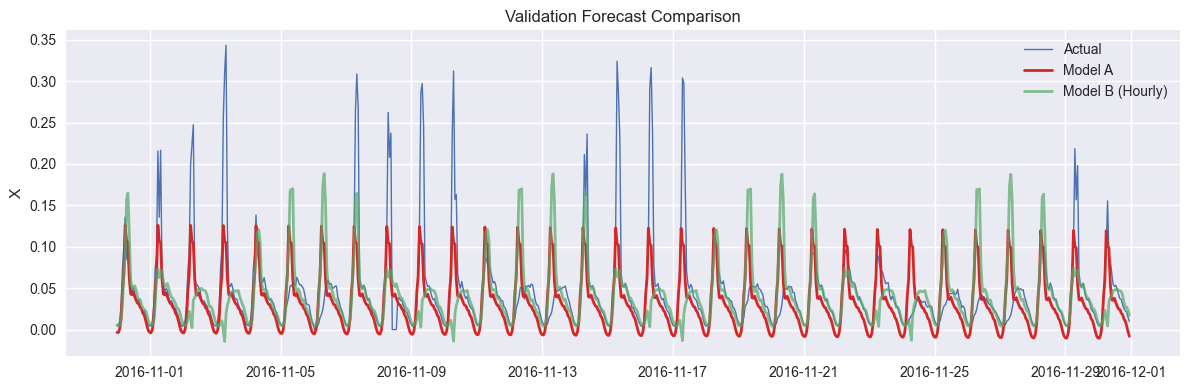

In [5]:

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(valid["DateTime"], valid["X"], label="Actual", lw=1)
ax.plot(valid["DateTime"], pred_valid_A, label="Model A", lw=2, color="tab:red")
ax.plot(valid["DateTime"], valid["UCM_hourly"], label="Model B (Hourly)", lw=2, alpha=0.7)
ax.set(title="Validation Forecast Comparison", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()


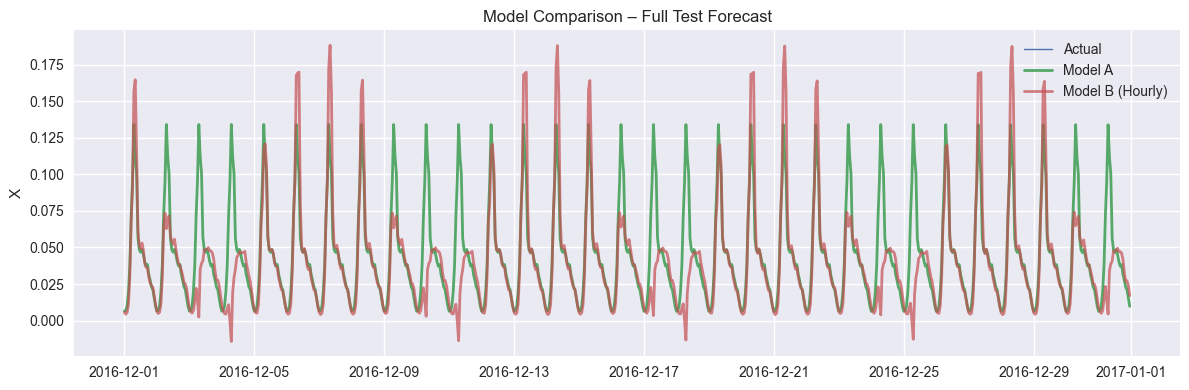

In [6]:

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test["DateTime"], test["X"], label="Actual", lw=1)
ax.plot(test["DateTime"], test_clean["UCM"], label="Model A", lw=2)
ax.plot(test["DateTime"], test["UCM_hourly"], label="Model B (Hourly)", lw=2, alpha=0.7)
ax.set(title="Model Comparison – Full Test Forecast", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()


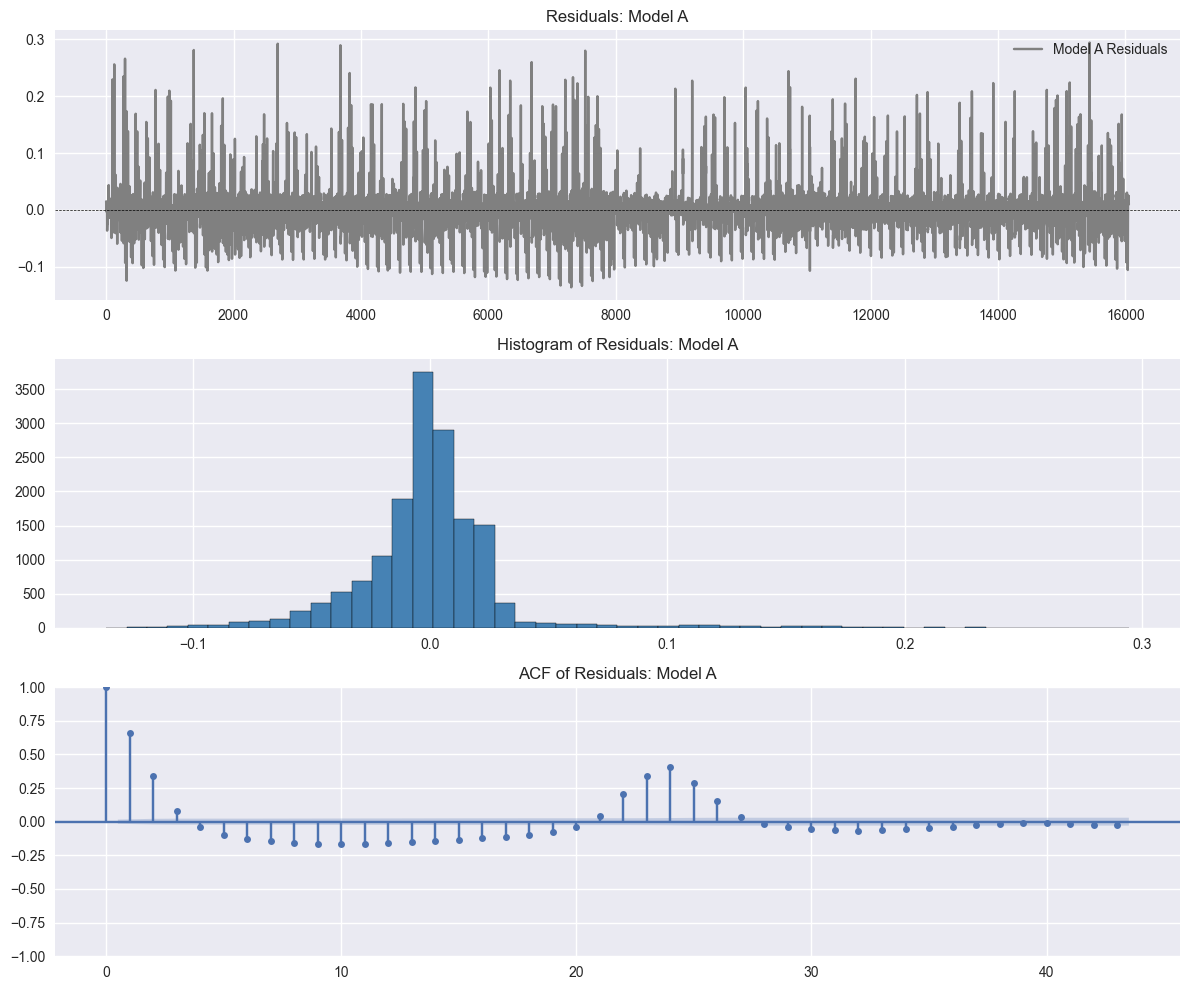

In [7]:

# Residual diagnostics for Model A
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axs[0].plot(fit_A.resid, label="Model A Residuals", color="gray")
axs[0].axhline(0, linestyle="--", color="black", lw=0.5)
axs[0].legend()
axs[0].set_title("Residuals: Model A")

axs[1].hist(fit_A.resid.dropna(), bins=50, color="steelblue", edgecolor="black")
axs[1].set_title("Histogram of Residuals: Model A")

plot_acf(fit_A.resid.dropna(), ax=axs[2])
axs[2].set_title("ACF of Residuals: Model A")

plt.tight_layout()
plt.show()


In [12]:
def make_exog(frame: pd.DataFrame, add_holidays=False) -> pd.DataFrame:
    """Return design matrix with:
       • 23 hour-of-day dummies (drop hour 0)
       • 6 weekday dummies       (drop Mon=0)
       • optional December-holiday dummies.
       Works even if DateTime column was not parsed properly.
    """
    # ensure DateTime is datetime64 dtype
    dt = pd.to_datetime(frame["DateTime"], errors="coerce")

    if dt.isnull().any():
        raise ValueError("Some 'DateTime' entries could not be parsed.")

    # basic seasonal dummies
    exog = (pd.get_dummies(dt.dt.hour,  prefix="hr",  drop_first=True)
              .join(pd.get_dummies(dt.dt.dayofweek, prefix="dow", drop_first=True)))

    if add_holidays:
        # common December holiday dummies
        specials = {
            "xmas_eve": (12, 24),
            "xmas_day": (12, 25),
            "boxing":   (12, 26),
            "nye":      (12, 31),
        }
        for name, (m, d) in specials.items():
            exog[name] = ((dt.dt.month == m) & (dt.dt.day == d)).astype(int)

    return exog.astype(int)


In [13]:
# Fast enhancement: Model B with holiday dummies as exogenous variables
print("Running fast enhancement: Model B + holiday dummies...")
mae_b_holidays = []
preds_valid_b_holidays = []

# Get exogenous matrices
X_train_holidays = make_exog(train, add_holidays=True)
X_valid_holidays = make_exog(valid, add_holidays=True)

for h in range(24):
    train_h = train[train["Hour"] == h]
    valid_h = valid[valid["Hour"] == h]

    y_train = train_h["X"]
    y_valid = valid_h["X"]

    # Align exog
    X_train_h = X_train_holidays.loc[train_h.index]
    X_valid_h = X_valid_holidays.loc[valid_h.index]

    # Fit UCM + exog
    fit = UCM(
        y_train,
        level="local linear trend",
        freq_seasonal=[{"period": 7, "harmonics": 3}],
        exog=X_train_h
    ).fit(disp=False)

    pred = fit.forecast(steps=len(y_valid), exog=X_valid_h)
    preds_valid_b_holidays.append(pd.Series(pred.values, index=valid_h.index))

    mask = y_valid.notna()
    if mask.sum() > 0:
        mae = mean_absolute_error(y_valid[mask].values, pred.values[mask])
        mae_b_holidays.append(mae)

# Combine forecasts and compute total MAE
valid["UCM_hourly_holidays"] = pd.concat(preds_valid_b_holidays).sort_index()
mae_b_holiday_total = mean_absolute_error(
    valid["X"].dropna(),
    valid["UCM_hourly_holidays"].loc[valid["X"].notna()]
)
print(f"[Model B + Holidays] Validation MAE: {mae_b_holiday_total:.4f}")

Running fast enhancement: Model B + holiday dummies...


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\st

[Model B + Holidays] Validation MAE: 0.0125


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Utente\AppData\Local\Temp\ipykernel_40320\2284322815.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [15]:
print("Model B + Holidays fitted MAE:", mae_b_holiday_total)

Model B + Holidays fitted MAE: 0.01252733111878769


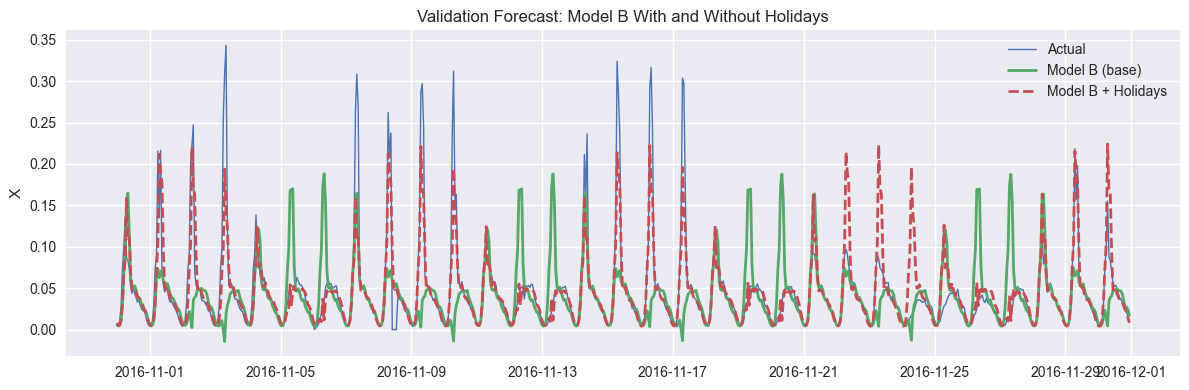

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(valid["DateTime"], valid["X"], label="Actual", lw=1)
ax.plot(valid["DateTime"], valid["UCM_hourly"], label="Model B (base)", lw=2)
ax.plot(valid["DateTime"], valid["UCM_hourly_holidays"], label="Model B + Holidays", lw=2, linestyle="--")
ax.set(title="Validation Forecast: Model B With and Without Holidays", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()

c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An u

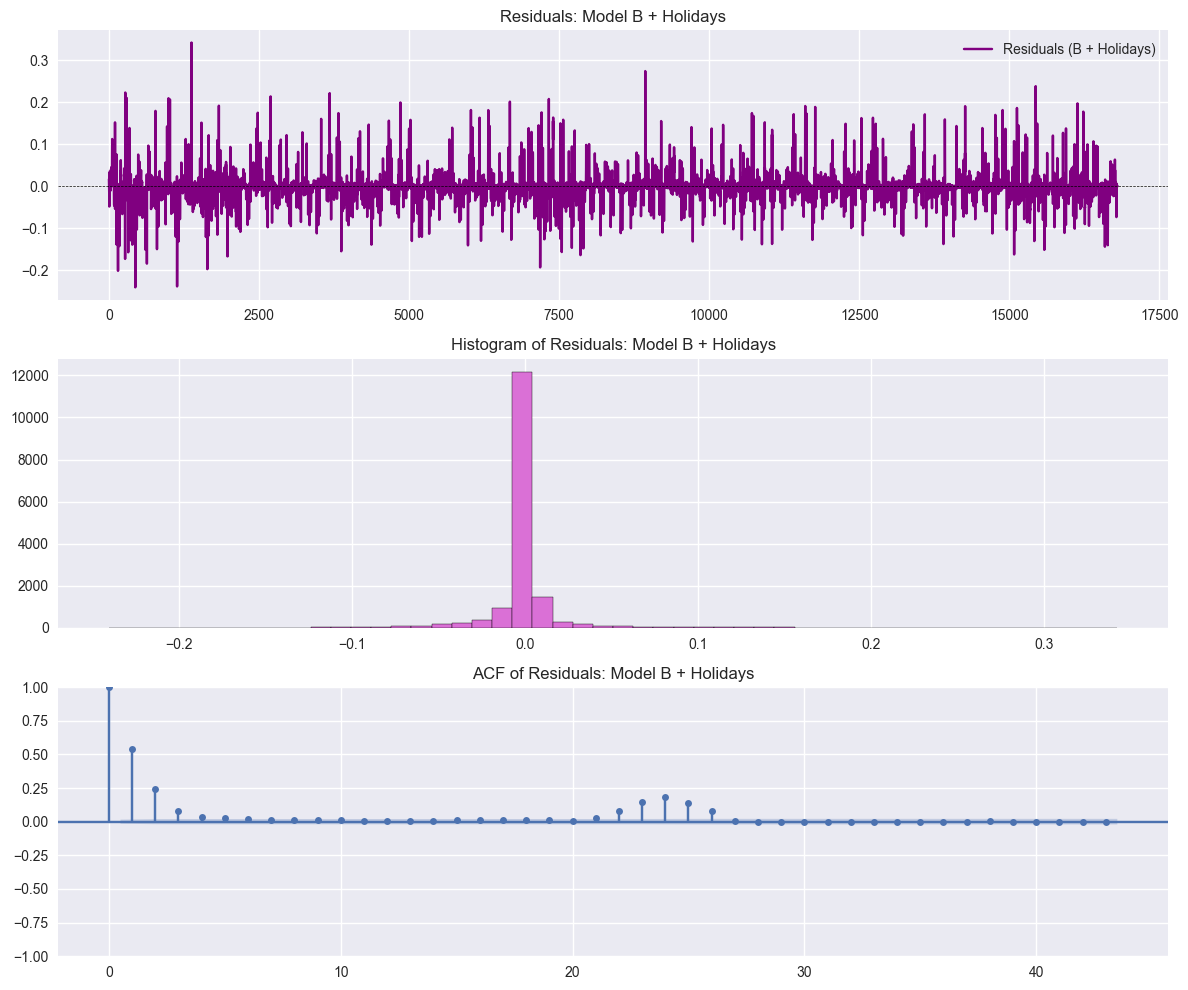

In [16]:
# Residual inspection for Model B + Holidays
residuals_b_holidays = []

for h in range(24):
    train_h = train[train["Hour"] == h]
    valid_h = valid[valid["Hour"] == h]
    trainval_h = pd.concat([train_h, valid_h])
    X_trainval_h = make_exog(trainval_h, add_holidays=True)

    fit = UCM(
        trainval_h["X"],
        level="local linear trend",
        freq_seasonal=[{"period": 7, "harmonics": 3}],
        exog=X_trainval_h
    ).fit(disp=False)

    residuals_b_holidays.append(trainval_h["X"] - fit.fittedvalues)

# Plot residual diagnostics
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

resid_all = pd.concat(residuals_b_holidays).sort_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 10))
axs[0].plot(resid_all, label="Residuals (B + Holidays)", color="purple")
axs[0].axhline(0, linestyle="--", color="black", lw=0.5)
axs[0].legend()
axs[0].set_title("Residuals: Model B + Holidays")

axs[1].hist(resid_all.dropna(), bins=50, color="orchid", edgecolor="black")
axs[1].set_title("Histogram of Residuals: Model B + Holidays")

plot_acf(resid_all.dropna(), ax=axs[2])
axs[2].set_title("ACF of Residuals: Model B + Holidays")

plt.tight_layout()
plt.show()


In [17]:
# Retrain Model B + Holidays on train + val, then forecast test
print("Retraining Model B + Holidays on full training data...")
trainval = pd.concat([train, valid])
X_trainval_holidays = make_exog(trainval, add_holidays=True)
X_test_holidays = make_exog(test, add_holidays=True)

test_preds_b_holidays = []

for h in range(24):
    trainval_h = trainval[trainval["Hour"] == h]
    test_h = test[test["Hour"] == h]

    X_trainval_h = X_trainval_holidays.loc[trainval_h.index]
    X_test_h = X_test_holidays.loc[test_h.index]

    fit = UCM(
        trainval_h["X"],
        level="local linear trend",
        freq_seasonal=[{"period": 7, "harmonics": 3}],
        exog=X_trainval_h
    ).fit(disp=False)

    forecast = fit.forecast(steps=len(test_h), exog=X_test_h)
    test_preds_b_holidays.append(pd.Series(forecast.values, index=test_h.index))

test["UCM_B_holidays"] = pd.concat(test_preds_b_holidays).sort_index()


Retraining Model B + Holidays on full training data...


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\

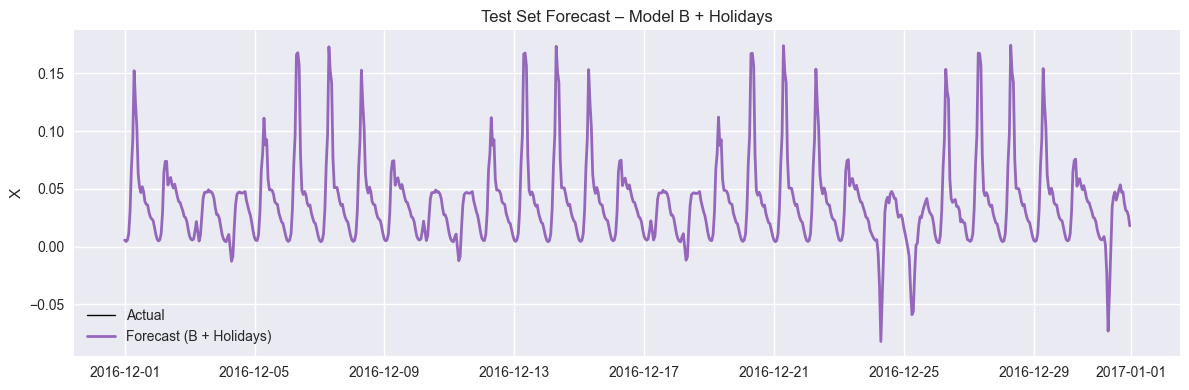

In [18]:
# Plot test set predictions for Model B + Holidays
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test["DateTime"], test["X"], label="Actual", lw=1, color="black")
ax.plot(test["DateTime"], test["UCM_B_holidays"], label="Forecast (B + Holidays)", lw=2, color="tab:purple")
ax.set(title="Test Set Forecast – Model B + Holidays", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()


In [19]:
# Save submission in requested format
submission = test[["DateTime"]].copy()
submission["UCM"] = test["UCM_B_holidays"]
submission.to_csv("./ts2024_ucm_b_holidays_test_forecast.csv", index=False)
submission.head()


,DateTime,UCM
16800,2016-12-01 00:00:00,0.005652
16801,2016-12-01 01:00:00,0.004411
16802,2016-12-01 02:00:00,0.005466
16803,2016-12-01 03:00:00,0.011159
16804,2016-12-01 04:00:00,0.030622


In [21]:
submission

,DateTime,UCM
16800,2016-12-01 00:00:00,0.005652
16801,2016-12-01 01:00:00,0.004411
16802,2016-12-01 02:00:00,0.005466
16803,2016-12-01 03:00:00,0.011159
16804,2016-12-01 04:00:00,0.030622
...,...,...
17539,2016-12-31 19:00:00,0.037875
17540,2016-12-31 20:00:00,0.031552
17541,2016-12-31 21:00:00,0.030519
17542,2016-12-31 22:00:00,0.026913
